Setup

In [1]:
import pandas as pd
import seaborn as sns 
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
import numpy as np
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import recall_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score,f1_score, classification_report
import time
from sklearn import tree
import graphviz

In [2]:
#import data
df = pd.read_csv("C:/Users/micls/OneDrive/Desktop/UC Berkelely AI CLASS/data/wa_churn.csv")
df = df.drop('customerID', axis =1)

In [3]:
#drop the clients with no internet or phone access, make yes/no binary, make male/female binary, 
df = df[df['DeviceProtection'] != 'No internet service']
df = df[df['MultipleLines'] != 'No phone service']

mapping = {'Yes': 1, 'No': 0}
df['Partner'] = df['Partner'].map(mapping)
df['Dependents'] = df['Dependents'].map(mapping)
df['PhoneService'] = df['PhoneService'].map(mapping)
df['OnlineSecurity'] = df['OnlineSecurity'].map(mapping)
df['OnlineBackup'] = df['OnlineBackup'].map(mapping)
df['DeviceProtection'] = df['DeviceProtection'].map(mapping)
df['TechSupport'] = df['TechSupport'].map(mapping)
df['StreamingTV'] = df['StreamingTV'].map(mapping)
df['StreamingMovies'] = df['StreamingMovies'].map(mapping)
df['PaperlessBilling'] = df['PaperlessBilling'].map(mapping)
df['MultipleLines'] = df['MultipleLines'].map(mapping)
df['Churn'] = df['Churn'].map(mapping)

mapping = {'Male': 1, 'Female': 0}
df['gender'] = df['gender'].map(mapping)

In [4]:
#One-Hot Encoding
dummies = pd.get_dummies(df['Contract'])
df = pd.concat([df, dummies], axis=1).drop('Contract',axis = 1)
dummies = pd.get_dummies(df['InternetService'])
df = pd.concat([df, dummies], axis=1).drop('InternetService',axis = 1)
dummies = pd.get_dummies(df['PaymentMethod'])
df = pd.concat([df, dummies], axis=1).drop('PaymentMethod',axis = 1)

In [5]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,Churn,Month-to-month,One year,Two year,DSL,Fiber optic,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
1,1,0,0,0,34,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,...,1,1,0,0,1,0,0,0,0,1
4,0,0,0,0,2,1,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
5,0,0,0,0,8,1,1,0,0,1,...,1,1,0,0,0,1,0,0,1,0
6,1,0,0,1,22,1,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0


In [6]:
#train test split
X = df.drop('Churn', axis = 1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

### Model Evaluation
fitting the most useful models from the exploratory data analysis

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#Logistic regression
lgr = Pipeline([('lgr', LogisticRegression())])


lgr_params = {'lgr__penalty' : ['l2', 'l1'],
             'lgr__fit_intercept' : [True, False],
             'lgr__C': [0.01, 0.1, 1, 10, 100]}
lgr_grid = GridSearchCV(lgr, lgr_params, cv=5)

start = time.time()
lgr_grid.fit(X_train_scaled, y_train)
stop = time.time()
lgr_params = lgr_grid.best_params_

lgr_time = stop - start
lgr_rec = recall_score(y_test, lgr_grid.predict(X_test_scaled))

C:\Users\micls\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\micls\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\micls\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\micls\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty,

In [8]:
#decision tree
dtree = Pipeline([('tree', DecisionTreeClassifier())])

dtree_params = {'tree__criterion' : ['gini', 'entropoy'],
              'tree__max_depth' : [None, 1, 2, 3, 4],
              'tree__min_samples_split' : [1, 2, 3, 4]}

dtree_grid = RandomizedSearchCV(estimator = dtree,
                   param_distributions = dtree_params,
                              scoring = 'recall')

start = time.time()
dtree_grid.fit(X_train, y_train)
stop = time.time()

dtree_time = stop - start
dtree_params = dtree_grid.best_params_
dtree_rec = recall_score(y_test, dtree_grid.predict(X_test))

C:\Users\micls\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\micls\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\micls\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\micls\anaconda3\Lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\micls\anaconda3\Lib\site-packa

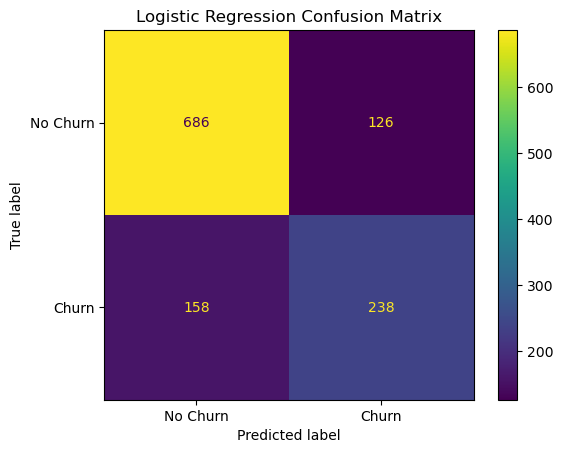

In [9]:

ConfusionMatrixDisplay.from_estimator(lgr_grid, X_test_scaled, y_test,display_labels=['No Churn',  'Churn'])  #confusion matrix and ROC chart maker
plt.title("Logistic Regression Confusion Matrix")
plt.show()

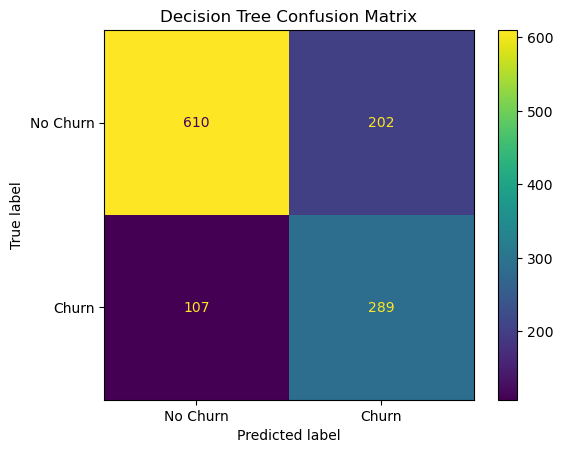

In [10]:

ConfusionMatrixDisplay.from_estimator(dtree_grid, X_test, y_test,display_labels=['No Churn',  'Churn'])  #confusion matrix and ROC chart maker
plt.title("Decision Tree Confusion Matrix")
plt.show()

In [11]:
print("Logistic Regression Model Statistics")
y_pred = lgr_grid.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
print("Logistic Regression Recall: {:0.5f}".format(recall_score(y_test, y_pred)))

Logistic Regression Model Statistics
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       812
           1       0.65      0.60      0.63       396

    accuracy                           0.76      1208
   macro avg       0.73      0.72      0.73      1208
weighted avg       0.76      0.76      0.76      1208

Logistic Regression Recall: 0.60101


In [12]:
print("Decision Tree Model Statistics")
y_pred = dtree_grid.predict(X_test)
print(classification_report(y_test, y_pred))
print("Decision Tree Recall: {:0.5f}".format(recall_score(y_test, y_pred)))

Decision Tree Model Statistics
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       812
           1       0.59      0.73      0.65       396

    accuracy                           0.74      1208
   macro avg       0.72      0.74      0.72      1208
weighted avg       0.76      0.74      0.75      1208

Decision Tree Recall: 0.72980


Recall is the best indicator of model performance because the churn data is skewed heavily towards no churn.
In the scope of this task we would rather have a false positive than a false negative, as identifying a more potential churn
customer is also valuable. 

# Model Interpretation

Text(0.5, 1.0, 'Logistic Regression Feature Importance')

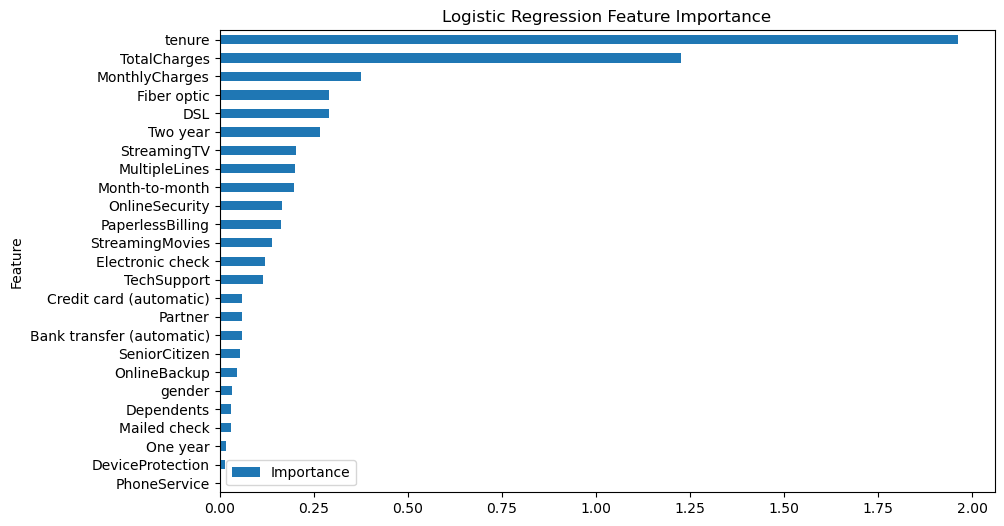

In [13]:
lgr = LogisticRegression(C = 100, fit_intercept = True , penalty = 'l2').fit(X_train_scaled, y_train)# best params from grid search
coefficients = lgr.coef_[0]
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title("Logistic Regression Feature Importance")

With the Logistic Regression model having a satisfactory recall score, we can extract the weights of each feature the model
Uses to make its classification. The features weights are shown side by side to visualize the magnitude of thier importance. 
Observations and insights can be made from looking at what is a high or low importnace feature, as well as the realative 
difference in magnitude between features. 

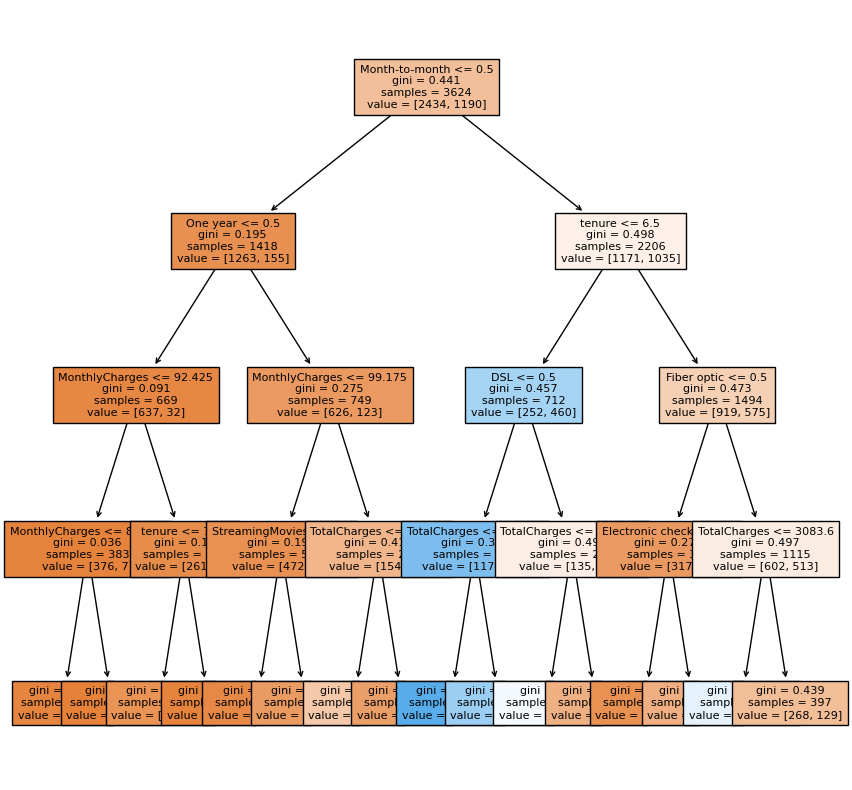

In [16]:
dtree = DecisionTreeClassifier(max_depth = 4, criterion = 'gini', min_samples_split = 4).fit(X_train, y_train)# best params from grid search
fig, ax = plt.subplots(figsize = (10, 10))
plot_tree(dtree, feature_names=list(X.columns), filled=True, ax = ax, fontsize=8);

With the decision tree classifier having a satisfactory score, we can look at the branches and make observations about
the groups of customers it came up with. The classifier in a way is grouping the samples based on values of thier features. 
Looking towards the root node we see that the classifier immediatly seperated clients based on thier month to month status.

# Model Validation

<Axes: xlabel='tenure', ylabel='MonthlyCharges'>

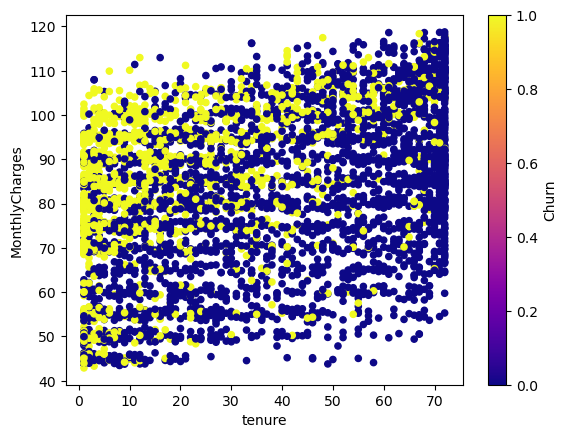

In [25]:
df.plot(x='tenure', y='MonthlyCharges', kind = 'scatter', c= 'Churn', colormap='plasma') 

From this map we can validate that when our logistic regression model says that tenure and MonthlyCharges are important
features, there is a trend/positive correlation for both of these and No Churn. The first True branch of the decision tree gives a tenure of 6.5 years to split, this may be a signifigant threshold number as most of the yellow points are before the 10 year tunure. 

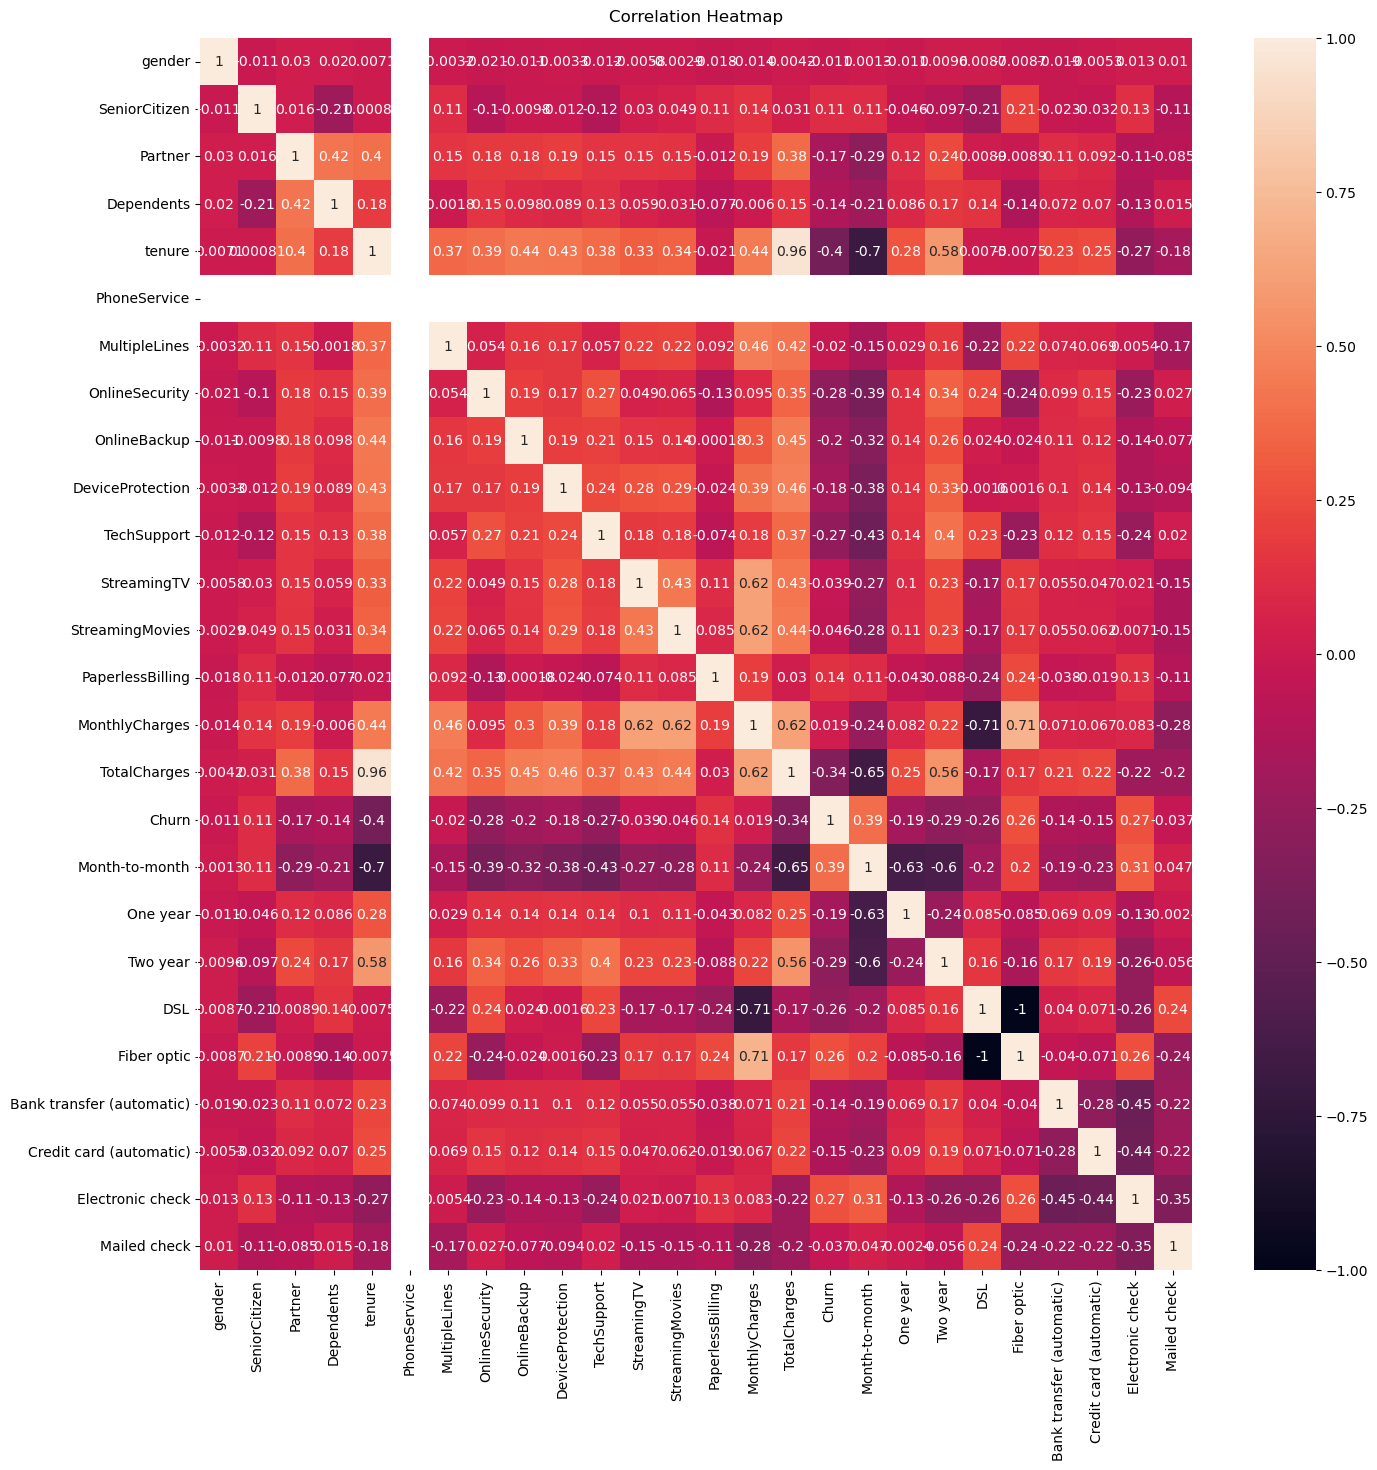

In [29]:
plt.figure(figsize=(16, 16))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [ ]:
The Correlation Heatmap will show what features may be related as well as thier correlation with Churn. 
This may be used side by side with the feature importnace graph to gain a better understanding. 

# Conclusion

This study shows how client information may be used to gain insight into whether they will churn. Certain combinations
of account information serve as trends and customers can be grouped into high risk of churn and low risk of churn. 

Some insights/conclusions we can make from the charts above: 
    
1. Tenure, Monthly charges, and total charges are the top indicators of churn.
2. Things like gender, senior citizen status, and dependents are not good indicators of churn. 
3. Clients using the fiber optic and electronic check services are churning at a higher rate, we may want to imporve those 
services. 
4. Month to month clients are churning at a high rate. 
5. If a customers tenure reaches 6.5 years they are much less likely to churn. 

# Future Work

Banks have much more data than shown in this project, a higher recall model with more interesting insights could be done 
with info such as credit score, debt, list of purchases, names, physical location, etc. Graphs can be made to represent the 
churn over time as well as any identify thresholds with features like charges. Data from multiple banks could be compared to
see what kinds of customers prefer which bank, and how marketing strategies can be devised to capture lacking demographics. 